# 1 : Importing the Data

In [3]:
import pandas as pd
import numpy as np

import matplotlib
# Create a clean configuration with only default values
matplotlib.rcParams.clear()
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# Fix the specific problematic parameter
matplotlib.rcParams['image.interpolation_stage'] = 'data'  # Use 'data' instead of 'auto'

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, silhouette_score

In [4]:
df = pd.read_csv('questionnaire.csv')

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10175 entries, 0 to 10174
Columns: 953 entries, SEQN to WHQ520
dtypes: float64(944), int64(7), object(2)
memory usage: 74.0+ MB
None
    SEQN  ACD011A  ACD011B  ACD011C  ACD040  ACD110  ALQ101  ALQ110  ALQ120Q  \
0  73557      1.0      NaN      NaN     NaN     NaN     1.0     NaN      1.0   
1  73558      1.0      NaN      NaN     NaN     NaN     1.0     NaN      7.0   
2  73559      1.0      NaN      NaN     NaN     NaN     1.0     NaN      0.0   
3  73560      1.0      NaN      NaN     NaN     NaN     NaN     NaN      NaN   
4  73561      1.0      NaN      NaN     NaN     NaN     1.0     NaN      0.0   

   ALQ120U  ...  WHD080U  WHD080L  WHD110  WHD120  WHD130  WHD140  WHQ150  \
0      3.0  ...      NaN     40.0   270.0   200.0    69.0   270.0    62.0   
1      1.0  ...      NaN      NaN   240.0   250.0    72.0   250.0    25.0   
2      NaN  ...      NaN      NaN   180.0   190.0    70.0   228.0    35.0   
3      NaN  ...      NaN    

# 2 :  Diabetes-Related Variables

#### From the NHANES data, we'll focus on variables related to diabetes screening. The key variables are:

#### DIQ010: Doctor told you have diabetes (target variable)

#### DID040: Age when first told you had diabetes

#### DIQ160: Ever told you have prediabetes

#### DIQ170: Ever told you have risk factors for diabetes

#### Other relevant variables like BMI, age, blood pressure, etc.

In [21]:
# The diabetes-related columns that actually exist in your dataset
diabetes_cols = ['DIQ010', 'DIQ160', 'DIQ170']  # These exist in your data

# For demographic information, replace with columns that exist
demographic_cols = ['MCQ010', 'MCQ025']  # Using general demographic columns from your list

# For health information, use columns that exist
health_cols = ['BPQ020', 'BPQ030', 'SMQ020']  # Blood pressure and smoking related  

# For diet information, use columns that exist
diet_cols = ['DBQ010', 'DBQ700', 'DBQ197']  # Diet related questions

# Combine all columns
all_cols = diabetes_cols + demographic_cols + health_cols + diet_cols

# Filter the dataframe to only include these columns
df_diabetes = df[all_cols].copy()

# Check the filtered dataframe
print(df_diabetes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10175 entries, 0 to 10174
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DIQ010  9769 non-null   float64
 1   DIQ160  6287 non-null   float64
 2   DIQ170  6469 non-null   float64
 3   MCQ010  9769 non-null   float64
 4   MCQ025  1538 non-null   float64
 5   BPQ020  6464 non-null   float64
 6   BPQ030  2174 non-null   float64
 7   SMQ020  6113 non-null   float64
 8   DBQ010  1865 non-null   float64
 9   DBQ700  6464 non-null   float64
 10  DBQ197  9769 non-null   float64
dtypes: float64(11)
memory usage: 874.5 KB
None


# 3 : Clean and Preprocessing data 

In [22]:
# Convert DIQ010 to binary target (1 = diabetes, 0 = no diabetes)
df_diabetes['DIABETES'] = df_diabetes['DIQ010'].replace({1: 1, 2: 0, 9: np.nan})  # 9 is missing/refused

# Drop rows where diabetes status is missing
df_diabetes = df_diabetes.dropna(subset=['DIABETES'])

# Handle missing values in other columns - using recommended approach to avoid warning
for col in df_diabetes.columns:
    if df_diabetes[col].dtype == 'float64':
        # For continuous variables, fill with median - avoiding inplace with chained assignment
        df_diabetes[col] = df_diabetes[col].fillna(df_diabetes[col].median())
    elif df_diabetes[col].dtype in ['object', 'int64']:
        # For categorical variables, fill with mode - avoiding inplace with chained assignment
        df_diabetes[col] = df_diabetes[col].fillna(df_diabetes[col].mode()[0])

# Convert categorical variables to dummy variables
categorical_cols = [col for col in ['MCQ010', 'MCQ025', 'SMQ020'] if col in df_diabetes.columns]
df_diabetes = pd.get_dummies(df_diabetes, columns=categorical_cols, drop_first=True)

# Drop original diabetes columns to avoid data leakage
df_diabetes = df_diabetes.drop(columns=diabetes_cols)

# Check the cleaned dataframe
print(df_diabetes.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9764 entries, 0 to 10174
Data columns (total 86 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   BPQ020          9764 non-null   float64
 1   BPQ030          9764 non-null   float64
 2   DBQ010          9764 non-null   float64
 3   DBQ700          9764 non-null   float64
 4   DBQ197          9764 non-null   float64
 5   DIABETES        9764 non-null   float64
 6   MCQ010_2.0      9764 non-null   bool   
 7   MCQ010_7.0      9764 non-null   bool   
 8   MCQ010_9.0      9764 non-null   bool   
 9   MCQ025_2.0      9764 non-null   bool   
 10  MCQ025_3.0      9764 non-null   bool   
 11  MCQ025_4.0      9764 non-null   bool   
 12  MCQ025_5.0      9764 non-null   bool   
 13  MCQ025_6.0      9764 non-null   bool   
 14  MCQ025_7.0      9764 non-null   bool   
 15  MCQ025_8.0      9764 non-null   bool   
 16  MCQ025_9.0      9764 non-null   bool   
 17  MCQ025_10.0     9764 non-null   bool 

# 4 : Data Analysis

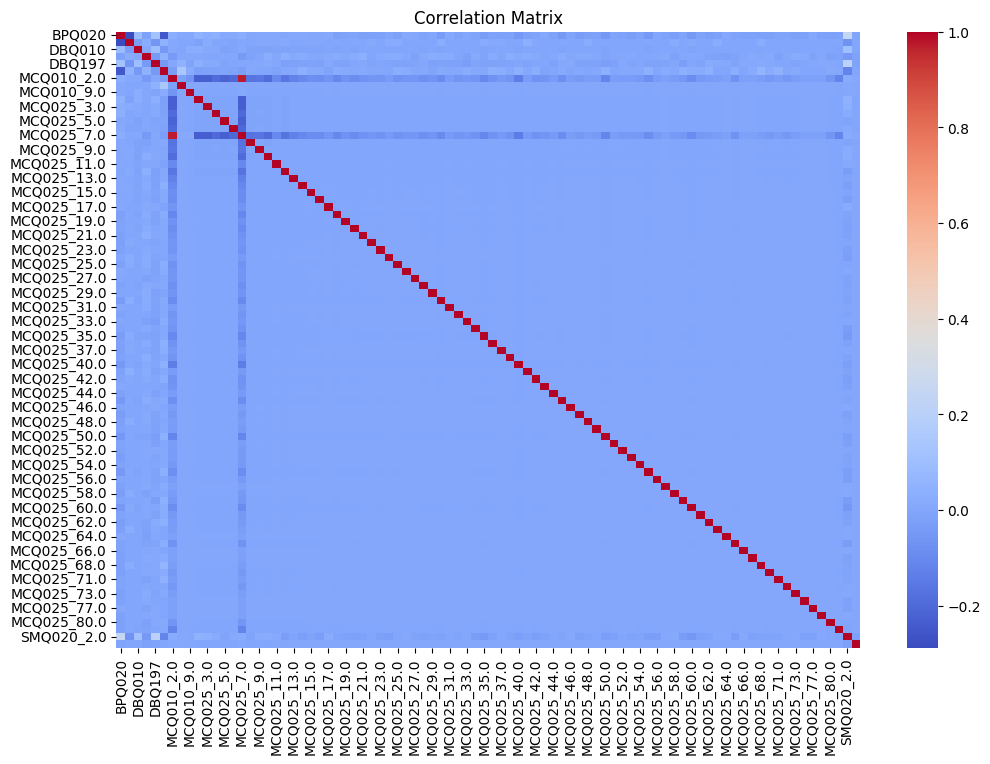

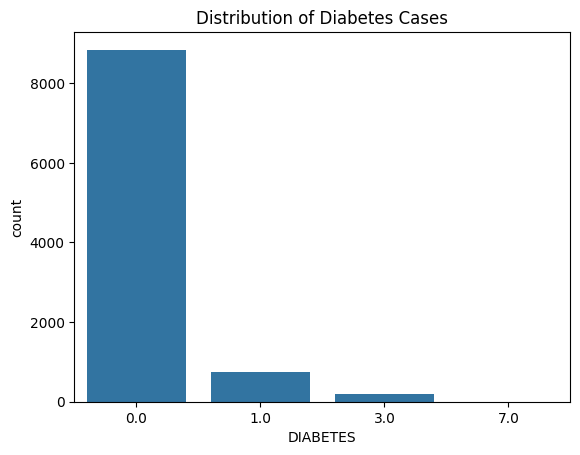

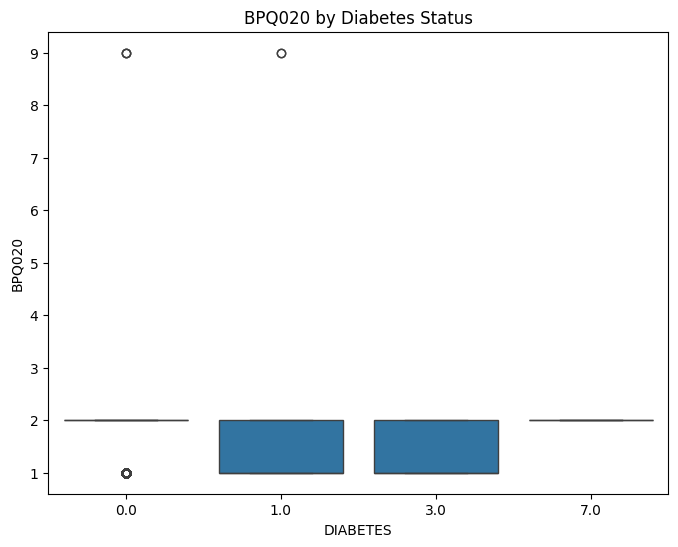

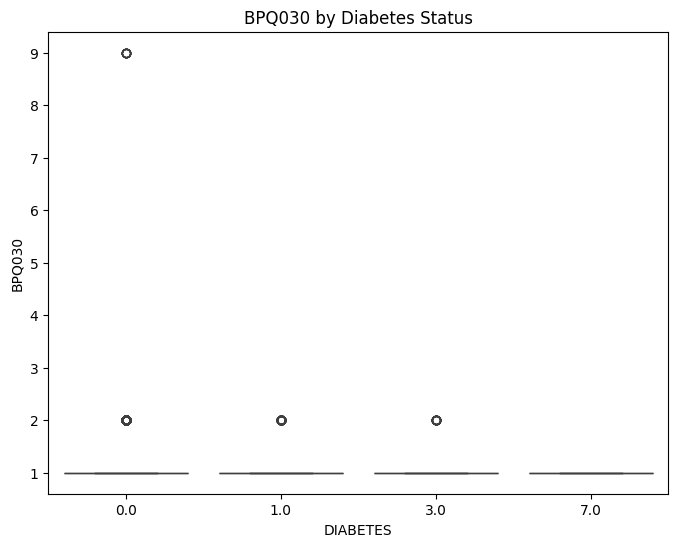

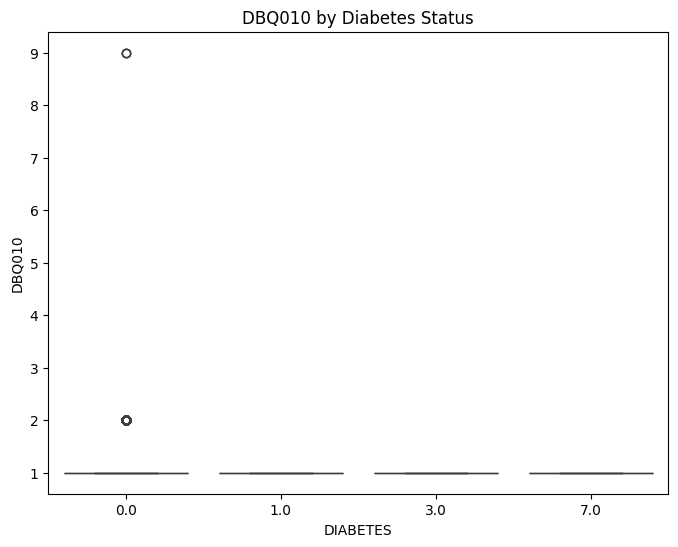

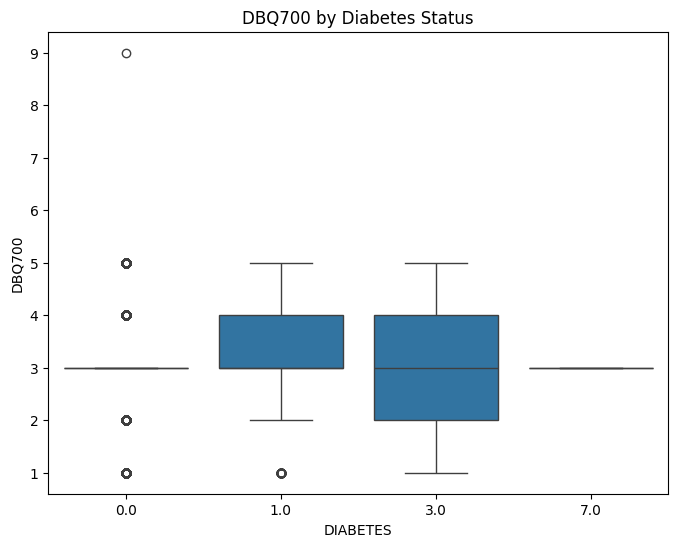

In [24]:
# Correlation matrix - this should work as is
plt.figure(figsize=(12, 8))
sns.heatmap(df_diabetes.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Matrix')
plt.show()

# Distribution of diabetes cases - this should work as is
sns.countplot(x='DIABETES', data=df_diabetes)
plt.title('Distribution of Diabetes Cases')
plt.show()

# Boxplots of key variables by diabetes status
# Replace with columns that actually exist in your dataset
available_columns = df_diabetes.select_dtypes(include=['float64', 'int64']).columns
# Exclude the DIABETES column and select up to 4 numeric columns for visualization
plot_columns = [col for col in available_columns if col != 'DIABETES'][:4]

for col in plot_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='DIABETES', y=col, data=df_diabetes)
    plt.title(f'{col} by Diabetes Status')
    plt.show()